#### Copyright 2018 Google LLC.

In [2]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Counterintuitive Challenges in ML Debugging

In this Colab, you will explore why ML debugging is harder than traditional debugging by debugging a simple regression problem, with one feature and one label. You will:

* Create the dataset.
* Try to fit the data with a simple model.
* Debug the model.
* Demonstrate exploding gradients.

Please **make a copy** of this Colab before running it. Click on *File*, and then click on *Save a copy in Drive*.

# Case Study: Debugging a Simple Model

## Create the Dataset

Run the cells below to load libraries.

In [3]:
# Reset environment for a new run
% reset -f

# Load Libraries
from os.path import join # for joining file pathnames
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Set Pandas display options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Create the data. Your data consists of one feature with values 0 to 9, and your labels are the same data with some noise added. In a dataset, by convention, rows are examples and columns are features. To match this convention, transpose your data. Before transposing your vectors, you must convert them to matrices.

In [4]:
features = np.array(range(10))
features = features[:, np.newaxis]
# Create labels by adding noise distributed around 0
labels = features + np.random.random(size=[10,1]) - 0.5

Verify that the data roughly lies in a straight line and, therefore, is easily predicted..


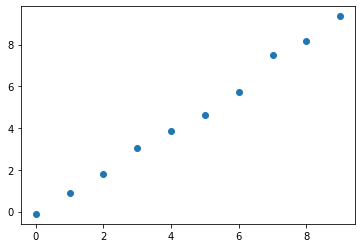

In [5]:
# Visualize the data
plt.scatter(features,labels)

## Fit Simple Data with Simple Model

TensorFlow provides several different APIs. This Colab only demonstrates the Keras API since Keras lets you quickly train models in a few lines of code using high-level APIs. In Keras, the typical neural network is a `sequential` model with fully-connected, or `dense`, layers.

Your dataset is simple. A neural network with just 1 neuron should learn your dataset. Define a neural network with 1 layer having 1 neuron using the model type `keras.Sequential` with the layer type `keras.layers.Dense`. To understand the Keras code, read the code comments. Then run the cell. The code prints the model summary to show a model with 1 layer and 2 parameters (weight and bias).

In [92]:
# Delete any existing assignment to "model"
model = None

# Use a sequential model
model = keras.Sequential()

# Add a layer with 1 neuron. Use the popular "tanh" activation function
model.add(keras.layers.Dense(units=1,             # 1 neuron
                             activation='linear',   # 'tanh'
                             input_dim=1))         # number of feature cols=1

# Model calculates loss using mean-square error (MSE)
# Model trains using Adam optimizer with learning rate = 0.001
model.compile(optimizer=keras.optimizers.SGD(0.009),
              loss='mse',
             )

print(model.summary())

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None


Now, train the model.

In [93]:
model.fit(x=features,
          y=labels,
          epochs=10,    # train for 10 epochs
          batch_size=10,# use 10 examples per batch
          verbose=1)    # verbose=1 prints progress per epoch

Epoch 1/10
1/1 [==============================] - 0s 437ms/step - loss: 29.1064
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 6.6120
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 1.5560
Epoch 4/10
1/1 [==============================] - 0s 15ms/step - loss: 0.4192
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1634
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.1056
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0923
Epoch 8/10
1/1 [==============================] - 0s 16ms/step - loss: 0.0890
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0879
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0873


Your loss stubbornly refuses to decrease! Review your approach keeping in mind the guidance on the [model development process](https://developers.google.com/machine-learning/testing-debugging/common/overview). 

The following list describes possible actions to debug your model. Read the actions and their explanations to understand how debugging in ML requires you to sort through multiple possibilities at once. If an action sounds promising, experiment by modifying the code above.

* **Transforming data**: You data is not transformed. You can experiment by transforming the data appropriately and retraining the model.
* **Activation function**: The `tanh` activation function cannot predict values >1. Besides, in a regression problem, the last layer should always use the linear activation function. Therefore, should you use  `activation='linear'`?
* **Hyperparameter values**: Should you adjust any hyperparameter values to try reducing loss?
* **Simpler model**: The model development process recommends starting with a simple model. A linear model is simpler than your nonlinear model. Should you use `activation='linear'`?
* **Change optimizer**: Your model uses the Adam optimizer. You can fall back to the gradient descent optimizer by using `optimizer=keras.optimizers.SGD()`.

Consider these actions and experiment where necessary. Then read the following section for the solution.

## Solution: Getting Loss to Decrease

Before trying to adjust specific model parameters, such as the hyperparameter values, you should first check for good development practices. Here, you should start with a linear model because of these two best practices:

* Regression: In a regression problem, the last layer must always be linear.
* Start simple: Since a linear model is simpler than a nonliner model, start with a linear model.

Run the following code to train a linear model and check if your loss decreases. The code displays the loss curve.

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 136.0511
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 135.0868
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 133.8663
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 132.9580
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 131.8815
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 130.7925
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 129.6664
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 128.7674
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 127.6603
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 126.9185


Text(0.5, 1.0, 'Loss Curves')

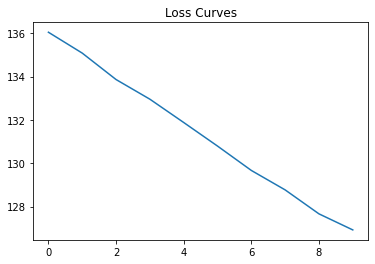

In [63]:
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, activation='linear', input_dim=1))
model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse')
trainHistory = model.fit(features, labels, epochs=10, batch_size=1, verbose=1)
# Plot loss curve
plt.plot(trainHistory.history['loss'])
plt.title('Loss Curves')

Your loss decreases, albeit slowly! You're on the right track. How can you get your loss to converge? Experiment with the code above. For the solution, read the following section.

## Solution: Reaching Convergence

Your loss isn't decreasing fast enough. From the guidance on [Learning Rate](https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate), you know that you can increase the learning rate to train faster. Run the following code to increase the learning rate to 0.1. The the model reaches convergence quickly.

In [64]:
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, activation='linear', input_dim=1))
model.compile(optimizer=tf.optimizers.Adam(0.1), loss='mse')
model.fit(features, labels, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
10/10 [==============================] - 0s 2ms/step - loss: 50.4100
Epoch 2/5
10/10 [==============================] - 0s 2ms/step - loss: 12.8322
Epoch 3/5
10/10 [==============================] - 0s 2ms/step - loss: 1.0999
Epoch 4/5
10/10 [==============================] - 0s 1ms/step - loss: 2.1706
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 1.5373


Wonderful, you quickly get a very low loss! Let's confirm the model works by predicting results for values [0,9] and superimposing them on top of the features.

1/1 [==============================] - 0s 40ms/step


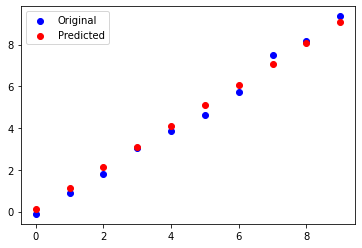

In [94]:
# get predictions
featuresPred = model.predict(features, verbose=1)
# Plot original features and predicted values
featuresPred = np.transpose(featuresPred)
plt.scatter(range(10), labels, c="blue")
plt.scatter(range(10), featuresPred, c="red")
plt.legend(["Original", "Predicted"])

Yes, the predictions match the features very well.

## Summary of Case Study

When debugging ML models, you should first attempt to diagnose the problem and apply the appropriate fix. For example, if you had changed your optimizer using `optimizer='sgd'`, then your model also converges faster. However, the problem was not with the optimizer but with the learning rate. Changing the optimizer only helps because `optimizer='sgd'` has a higher default learning rate than `optimizer='adam'`.

Alternatively, you could train the model for longer with the default learning rate. However, in real-world ML, models take long to train. You should keep your training cycles as short as possible. Therefore, increasing the learning rate is the correct fix.

These options demonstrate how debugging in ML is n-dimensional, and therefore you must use your understanding of model mechanics to narrow down your options. Because running experiments in ML is time consuming, requires careful setup, and can be subject to reproducibility issues, it's important to use your understanding of model mechanics to  narrow down options without having to experiment.

Lastly, according to development best practices, you should transform your feature data appropriately. This Colab did not transform the feature data because transformation is not required for convergence. However, you should always transform data appropriately. Here, you could normalize your feature data using z-score or scale the feature data to [0,1]. 

# Exploding Gradients

A common problem in model training is a loss that "explodes" or becomes `nan`. A common cause is anomalous feature data, such as outliers and `nan` values, or a high learning rate. The following sections demonstrate these causes.

## Cause: High Learning Rate

In this section, you will create data in the range [0,50] and show that the gradient explodes when you train the model using a learning rate of 0.01. Then you'll reduce the learning rate to make the model converge.

Create and visualize the data by running the following code.

In [ ]:
# create data with large values
features = np.array(range(50))
# generate labels
labels = features + np.random.random(features.shape) - 0.5

# Transpose data for input
[features, labels] = [features.transpose(), labels.transpose()]

plt.scatter(range(len(features)), features)

Run the following cell to train a model with a learning rate of 0.01. You will get `inf` for your loss.

In [ ]:
# Train on raw data
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim=1, activation='linear'))
model.compile(optimizer=keras.optimizers.SGD(0.01), loss='mse')
model.fit(features, labels, epochs=5, batch_size=10, verbose=1)

To demonstrate that the high learning rate makes the loss explore, reduce the learning rate to `0.001`. Your loss will converge.

# Conclusion

This Colab demonstrated the following principles.

* The n-dimensional nature of debugging in ML makes ML debugging hard.
* For effective debugging, understanding model mechanics is important.
* Start with a simple model.
* Exploding gradients incorrect normalization in the model, mis-configuration of FeatureColumns, etc., than raw data containing NaNs.